# Bayesian Model for Sleeping and Waking Up

## Problem Description

My Garmin Vivosmart tracks the time I fall asleep and wake up each day. I would like to create a model that returns the probability I am asleep at a given time. That is, given that we know the time, what is the probability I am asleep? This posterior can be expressed as $p(sleep | time)$.

## Approach 

We will assume the transition from waking to sleeping is modeled as a logistic function. To find the parameters of the logistic function, we can use Markov Chain Monte Carlo sampling of the parameters informed by the data. We will assume the priors for the parameters are normal distributions and the algorithm will attempt to maximize the likelihood of the parameters given the data. The return values from the MCMC will be the randomly drawn samples from the posterior for the parameters. We can then create the most likely logistic function using the average values of the samples. 

The end outcome will be two models, one for sleep and one for waking up, which will return the probability of being asleep at a given time. We could simply use a frequentist approach and say that the probability of being asleep is equal to the observed probability at that time, but the measured values are not the true values. Using Bayesian Inference will allow us to find the probability of being asleep which reflects the uncertainty around modeling real-world data. We will make extensive use of the [PyMC3 library](https://github.com/pymc-devs/pymc3) in this report. 

In [120]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('style/bmh_matplotlibrc.json'))
matplotlib.rcParams.update(s)

matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14

# Parameter for changing the number of sampling steps
N_SAMPLES = 5000

# Wake Sleep Data

The Wake and Sleep data contains about two months of observations. The Garmin is definitely not 100% accurate, because often it will think I'm sleeping if I turn off notifications and read in bed. Sometimes we have to deal with imperfect data, and because the truthful observations outweight the false, they should have a larger impact on the model. 

In [2]:
data = pd.read_csv('data/sleep_wake.csv')
data.set_index('Date', inplace=True, drop=True)
data.index=data.index.to_datetime(dayfirst=False)
data = data.ix[:, 0:2]

In [3]:
data['Sleep_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=22) for entry in zip(data.index, data['Sleep'])]
data['Wake_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=6) for entry in zip(data.index, data['Wake'])]
data.head()

,Sleep,Wake,Sleep_time,Wake_time
2017-12-01,16,1,2017-12-01 22:16:00,2017-12-01 06:01:00
2017-12-02,19,-10,2017-12-02 22:19:00,2017-12-02 05:50:00
2017-12-03,-45,0,2017-12-03 21:15:00,2017-12-03 06:00:00
2017-12-04,8,1,2017-12-04 22:08:00,2017-12-04 06:01:00
2017-12-05,-23,-16,2017-12-05 21:37:00,2017-12-05 05:44:00


## Data Structuring

In [4]:
# Create a separate sleep dataframe
sleep_index = pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
sleep_index = [time for time in sleep_index if (time.hour >= 21) & (time.hour <= 23)]
sleep_data = pd.DataFrame(0, columns=['indicator'], index=sleep_index)

# Set an index with an indicator for times when I am asleep
# Indicator = 1 when I am asleep, else 0
for time in sleep_data.index:
    for sleep_time in data['Sleep_time']:
        if time == sleep_time:
            selected_date = time.date()
            date_subset = [date for date in sleep_data.index if date.date() == selected_date]
            asleep_times = [time for time in date_subset if time.time() >= sleep_time.time()]
            sleep_data.ix[asleep_times, 'indicator'] = 1
            
# Create a separate wake dataframe
wake_index=pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
wake_index = [time for time in wake_index if (time.hour <= 7) & (time.hour >= 5)]
wake_data = pd.DataFrame(1, columns=['indicator'], index=wake_index)

# Set an index with indicator for times when I am asleep
# Indicator = 1 when I am asleep, else 0
for time in wake_data.index:
    for wake_time in data['Wake_time']:
        if time == wake_time:
            selected_date = time.date()
            date_subset = [date for date in wake_data.index if date.date() == selected_date]
            wake_times = [time for time in date_subset if time.time() >= wake_time.time()]
            wake_data.ix[wake_times, 'indicator'] = 0
    
# Time offset column 
# For sleep, offset from 10:00 PM
sleep_data['time_offset'] = [int((time.hour * 60 + time.minute) - (22 * 60)) for time in sleep_data.index]
# For wake, offset from 6:00 AM
wake_data['time_offset'] = [int((time.hour * 60 + time.minute) - (6 * 60)) for time in wake_data.index]

In [5]:
# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

## Visualizations of Data

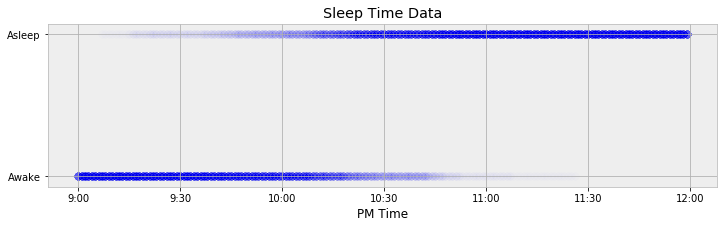

In [6]:
figsize(12, 3)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); plt.title('Sleep Time Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

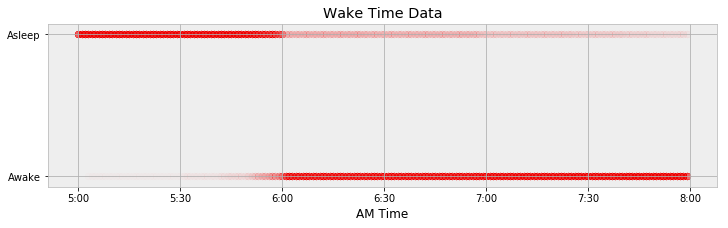

In [7]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], s= 50, alpha = 0.01, 
            facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time'); plt.title('Wake Time Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

# Modeling Transition as a Logistic Function

We want to find some model that expressions the transition from awake to asleep (or vice versa) as a function of time. The function must take values between 0 and 1 and increase to 1 as the time past 10 increases. There are a number of options, but here I will choose the logistic function. A logistic function is of the form 

$$p(t) = \frac{1}{ 1 + e^{\;\beta t } }$$

The variable we do not know is $\beta$ which controls the shape of the distribution. The following graphs show the logistic function with different values of $\beta$

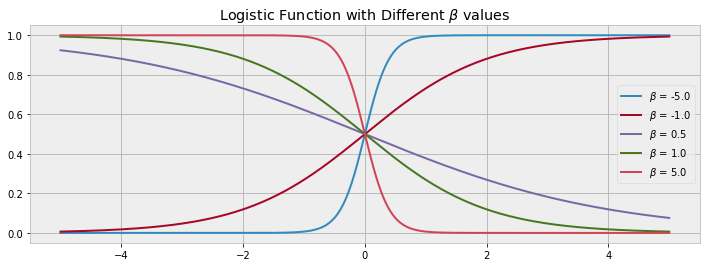

In [8]:
figsize(12, 4)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

There is one problem with the basic logistic function: the transition might not occur at 0 (which is 10:00 pm for sleeping and 6:00 am for waking). We can add an offset, called a bias, to adjust the location of the logistic function. We will call this parameter $\alpha$ and will also learn this from the data. The logistic function is now:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

Different values of alpha are shown below.

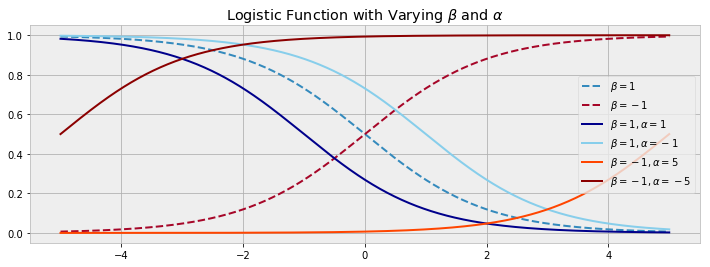

In [9]:
# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-5, 5, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1$", ls="--", lw=2)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, 1, -1), label=r"$\beta = 1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -1, 5), label=r"$\beta = -1, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -1, -5), label=r"$\beta = -1, \alpha = -5$", color="darkred")
plt.legend();
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

$\beta$ shifts the direction and steepness of the curve, while $\alpha$ changes the location. We will need to use the data to find the most likely value of these parameters for both sleeping and waking. 

# Assume Priors are Normally Distributed

We have no idea what the prior distributions for the model parameters are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal distribution is entirely defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the standard deviation, $\sigma$. The mean defines the location of the distribution and the precision is the spread. A larger value of $\tau$ indicates the data is less spread out and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

Probability density functions for three normal distributions are shown below.

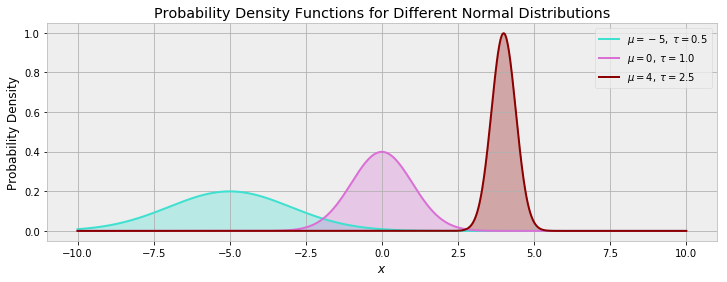

In [10]:
import scipy.stats as stats

# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("turquoise", "orchid", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1/param[1])
    plt.plot(x, y, label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend();
plt.xlabel("$x$")
plt.ylabel("Probability Density")
plt.title("Probability Density Functions for Different Normal Distributions");

The expected value of a normal distribution is the mean. 
$$ E[ X | \mu, \tau] = \mu$$ 

with the variance equal to:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

We have no prior assumptions about the value for either $\mu$ or $\tau$ for the two parameters in our logistic function $\alpha$ and $\beta$. When we initialize the model, we can use $\mu = 0$ and a relatively large variance such as $\tau = 0.05$

# Complete Model

We have all the pieces and it is time to put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean and a variance. 

## Bernoulli Variable

A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The variable is a function of the time, so we need a model that outputs a probability for being asleep given the time. The final model looks like

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t_i)$ is the logistic function for each value of time.

$$ p(t_i) = \frac{1}{1 + e^{(\beta t_i + \alpha)}}$$

with the unknown parameters $\beta$ and $\alpha$ assumed to come from a normal distribution.

## Sleep Model

First we will create a model for the sleep data. We use a Markov Chain Monte Carlo simluation to draw thousands of samples from the posterior distribution of $\alpha$ and $\beta$

### PyMC3 

We are using a powerful Bayesian Inference library in Python called PyMC3. This library has features for running Markov Chain Monte Carlo and other inference algorithms. This report does not detail PyMC3, but a great book for getting started is _Probabilistic Programming and Bayesian Methods for Hackers_ by Cameron Davidson-Pilon which is available for free on [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

In [35]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [36]:
import pymc3 as pm
import theano.tensor as tt
import scipy

In [37]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.05, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.05, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.


The trace contains all of the samples drawn from the posterior for alpha and beta. We can graph these samples to explore what they look like. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples usually about 50%, which are known as the burn-in samples. The algorithm does not immediately converge and the later samples are generally more representative of the data. 

## Visualize Posteriors for Alpha and Beta

The values returned by the MCMC are samples drawn from the posterior and hence represent an approximation of the posterior distribution. The best way to look at these values is to depict them as histograms.  

In [38]:
# Extract the alpha and beta samples
# Currently using all, including the burn-in period
alpha_samples = sleep_trace["alpha"][:, None]
beta_samples = sleep_trace["beta"][:, None]

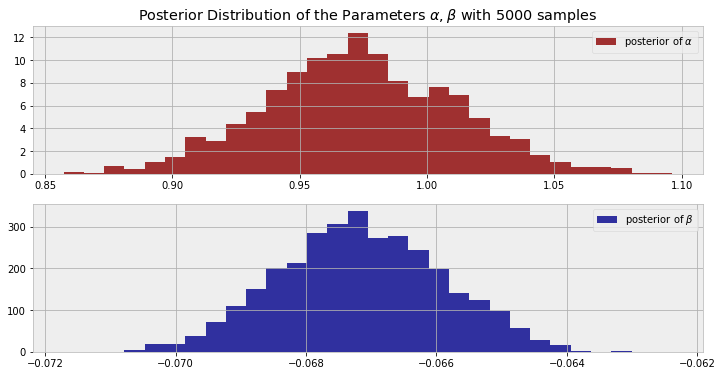

In [39]:
figsize(12, 6)

plt.subplot(211)
plt.title(r"Posterior Distribution of the Parameters $\alpha, \beta$ with %d samples" % N_SAMPLES)
plt.hist(alpha_samples, histtype='stepfilled', color = 'darkred', 
         bins=30, alpha=0.8, label=r"posterior of $\alpha$", normed=True);
plt.legend()

plt.subplot(212)

plt.hist(beta_samples, histtype='stepfilled', color = 'darkblue',
         bins=30, alpha=0.8, label=r"posterior of $\beta$", normed=True)
plt.legend();

If the $\beta$ values were centered around 0 that would indicate the time has no effect on the probability of being asleep. The $\alpha$ values also are not at 0, indicating that there is an offset from 10:00 pm in terms of being asleep. 

The spread of the data gives us a measure of uncertainty about the data. A larger spread indicates more uncertainty. As there is some overlap between awake and asleep, the uncertainty is expected to be large. 

To show the results of the model, we can create the logistic function with the most likely values of $\alpha$ and $\beta$ which we can take to be the mean of the posterior samples. 

In [40]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

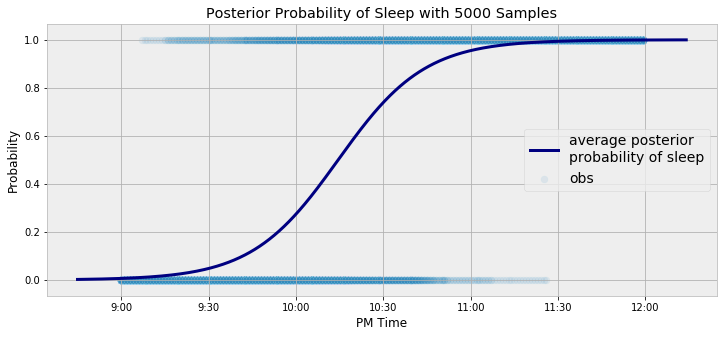

In [41]:
figsize(12, 5)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="average posterior \nprobability of sleep")
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1, label='obs')
plt.title('Posterior Probability of Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

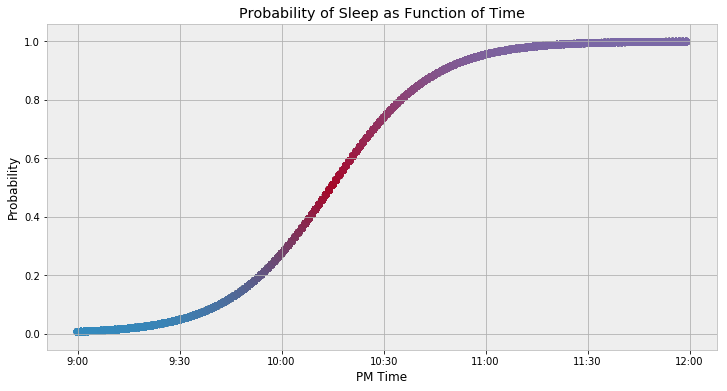

In [42]:
import matplotlib as mpl

colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

This is helpful, and now we can pass in any time and receive an estimated probability that I am asleep. The time is passed in as an offset from 10:00 pm.

In [43]:
print('10:00 PM probability of being asleep: {:.2f}%.'.format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 27.42%.
9:30  PM probability of being asleep: 4.80%.
10:30 PM probability of being asleep: 73.91%.


### Confidence Interval

There are many other diagnostics of the model that we can perform. For example, we know there is a considerable amount of uncertainty in our parameter estimates. A better way to show the graph therefore would be to include the 95% confidence interval at each time. 

In [44]:
from scipy.stats.mstats import mquantiles

sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

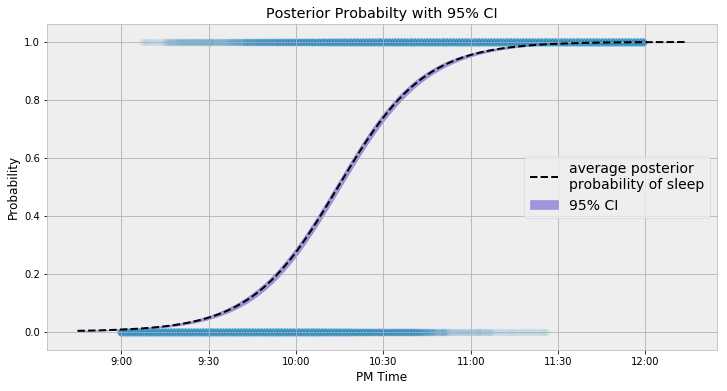

In [45]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); plt.title('Posterior Probabilty with 95% CI');

## Posterior Probability for Specific Time

We can plot the posterior distribution for time where each estimate is taken using all the samples from the Markov Chain Monte Carlo. This gives us a look at the uncertainty in the model. Each estimate is made using different values from the sampling.

In [46]:
def sleep_posterior(time_offset):
    figsize(12, 4)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=2)
    plt.title('Posterior Distribution for Sleep Gven time offset = %d' % time_offset)
    plt.xlabel('Probability of Sleep'); plt.ylabel('Samples')
    plt.show();

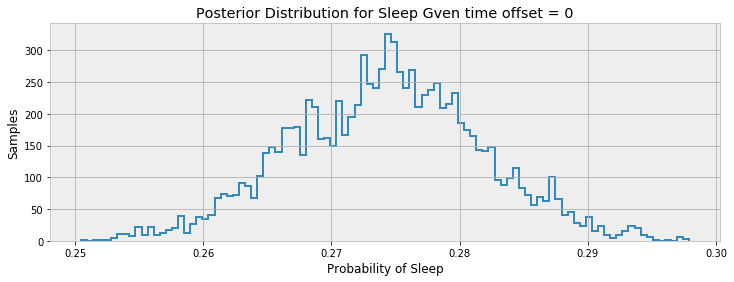

In [47]:
sleep_posterior(0)

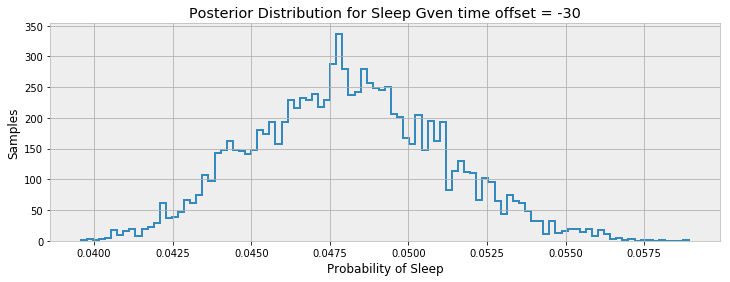

In [48]:
sleep_posterior(-30)

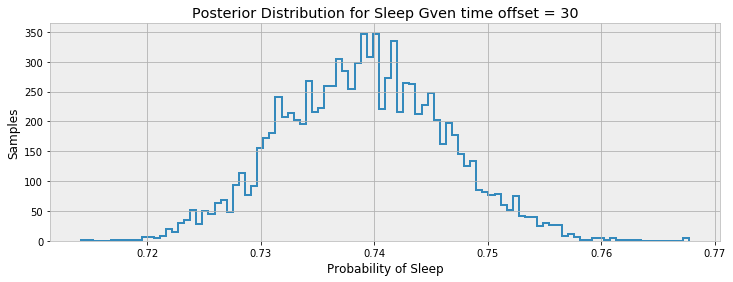

In [49]:
sleep_posterior(30)

# Convergence in Markov Chain Monte Carlo

How can we know if the model converged? We can look at the trace, or the path of the values over sampling. Another option is to look at the auto-correlation of the samples. In Markov Chain modeling, the samples are correlated with themselves because the next value depends on the current state (or the current state and past states based on the order). Initially, the algorithm tends to wander about the search space and will have a high auto-correlation. As the algorithm converges, the samples will settle down around a value and one measure of convergence is a low auto-correlation. 

## Trace Plots

We can start off making traces of $\alpha$ and $\beta$ parameters as the algorithm progresses.
There is a burn in period, and usually this is removed from the samples because it is not indicative of the final converged values. 

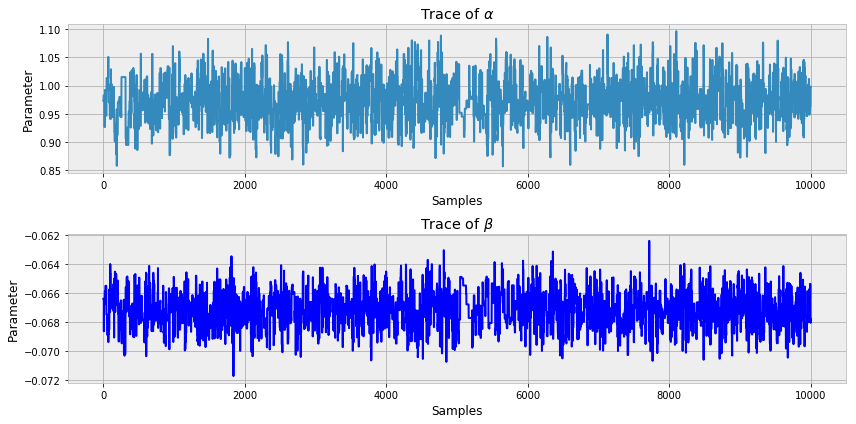

In [50]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples)
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)


# Incorporating Additional Information

The model we have currently returns the probability I am asleep given only the time. There are additional pieces of information such as if my bedroom light is on, or if my phone is charging, that would improve the model. The way to incorporate additional evidence in Bayesian inference is by using Bayes Rule. We can use the posterior probability for if I am asleep as the prior in the new model. I don't have data on the likelihoods for my light and phone, but I can provide estimates based on habits. Following are the likelihoods for these pieces of evidence:

$$P(L=1|s) = 0.01$$
$$P(L=1|\bar{s}) = 0.90$$

and 

$$P(C=1|s) = 0.95$$
$$P(C=1|\bar{s}) = 0.40$$

Where $L=1$ indicates my bedroom light is on and $C=1$ indicates my phone is charging.

Applying Baye's Equation, the probability I am asleep at a given time knowing the condition of my light and phone is:

$$P(s|L,C) = \frac{P(L,C|s)P(s)}{P(L,C)}$$

I will assume that my bedroom light and phone charging are conditionally independent of one another with the knowledge of whether or not I am asleep. This means that the probabilty of my light being on and my phone charging are not dependent if we know I am asleep or not.

$$P(L,C|s) = P(L|s) * P(C|s)$$

Baye's Equation then becomes:

$$P(s|L,C) = \frac{P(L|s)P(C|s) * P(s)}{P(L|s)P(C|s) * P(s) + P(L|\bar{s})P(C|\bar{s}) * P(\bar{s})}$$

Where $P(s)$ is the prior probability of my being asleep from the Markov Chain Monte Carlo Bayesian Inference.

The first step is to write a simple function which will compute the prior of sleep given the parameters from the MCMC.

In [51]:
alpha_sleep_est = alpha_est
beta_sleep_est = beta_est

In [70]:
# Returns the prior based on the average parameters from MCMC
def sleep_prior(time_offset):
    return logistic(time_offset, beta=beta_sleep_est, alpha=alpha_sleep_est)

In [110]:
# Returns the posterior probability of sleep given the time and condition of the light and phone
def sleep_posterior(time_offset, light, charge, 
                    light_likelihood_sleep=0.01, light_likelihood_awake=0.90,
                    charge_likelihood_sleep=0.95, charge_likelihood_awake=0.40):
    prior_sleep = sleep_prior(time_offset)
    prior_awake = 1 - prior_sleep
    
    # Change the priors based on the evidence
    if not light:
        light_likelihood_sleep = 1 - light_likelihood_sleep
        light_likelihood_awake = 1 - light_likelihood_awake
    if not charge:
        charge_likelihood_sleep = 1 - charge_likelihood_sleep
        charge_likelihood_awake = 1 - charge_likelihood_awake
       
    # Calculate the numerator and denominator in Baye's Equation
    numerator = light_likelihood_sleep * charge_likelihood_sleep * prior_sleep
    denominator = numerator + light_likelihood_awake * charge_likelihood_awake * prior_awake

    # Return the posterior probability
    posterior_sleep = numerator / denominator 
    return posterior_sleep

We can now use this model to make predictions with more information. 

Let's try a few and compare them to the prior. First up, what is the probability I am asleep at 10:00 pm if my light is off and my phone charging?

In [111]:
print('The prior for this case is     {:.2f}%.'.format(100 * sleep_prior(0)))
print('The posterior for this case is {:.2f}%.'.format(100 * sleep_posterior(0, 0, 1)))

The prior for this case is     27.42%.
The posterior for this case is 89.88%.


How about if it is 10:30 pm, my light is on, and my phone is charging?

In [112]:
print('The prior for this case is     {:.2f}%.'.format(100 * sleep_prior(30)))
print('The posterior for this case is {:.2f}%.'.format(100 * sleep_posterior(30, 1, 1)))

The prior for this case is     73.91%.
The posterior for this case is 6.96%.


One more situation. It is 9:45 pm, my light is off, and my phone is not charging.

In [113]:
print('The prior for this case is     {:.2f}%.'.format(100 * sleep_prior(-15)))
print('The posterior for this case is {:.2f}%.'.format(100 * sleep_posterior(-15, 0, 0)))

The prior for this case is     12.12%.
The posterior for this case is 10.22%.


We can see how incorporating more information changes the estimate. With more quality data, the model would be more accurate. This is a great example of Bayesian Inference, where we update our beliefs to incorporate more information. Bayesian Inference means becoming less wrong about the world!

## Visualize Shifts

To show how this information changes, we can make the same plots as before but with the additional information. There are four additional situations that shift the curve. 

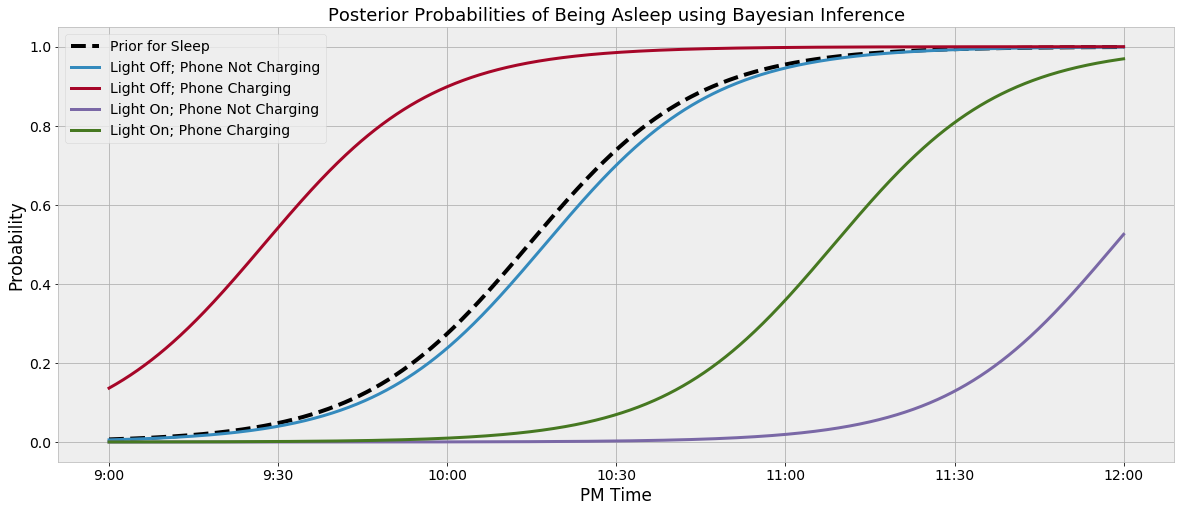

In [124]:
figsize(20, 8)

x = np.linspace(-60, 120, 1e3)
priors = logistic(x, beta=beta_sleep_est, alpha=alpha_sleep_est )

evidence = [[0, 0], [0, 1], [1, 0], [1, 1]]
labels = ['Light Off; Phone Not Charging', 'Light Off; Phone Charging', 
          'Light On; Phone Not Charging', 'Light On; Phone Charging']

plt.plot(x, priors, label='Prior for Sleep', ls = '--', color = 'k', lw = 4)

for i, obs in enumerate(evidence):
    posteriors = []
    for time_offset in x:
        posterior = sleep_posterior(time_offset, obs[0], obs[1])
        posteriors.append(posterior)
 
    plt.plot(x, posteriors, label=labels[i], lw = 3)


plt.legend(prop={'size':14}); plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels)
plt.xlabel('PM Time'); plt.ylabel('Probability')
plt.title("Posterior Probabilities of Being Asleep using Bayesian Inference", size = 18);
plt.show();

# Wake Model

We can repeat the same procedure with the wake data. The process is exactly the same we are just using different data. 

In [28]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.05, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.05, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.


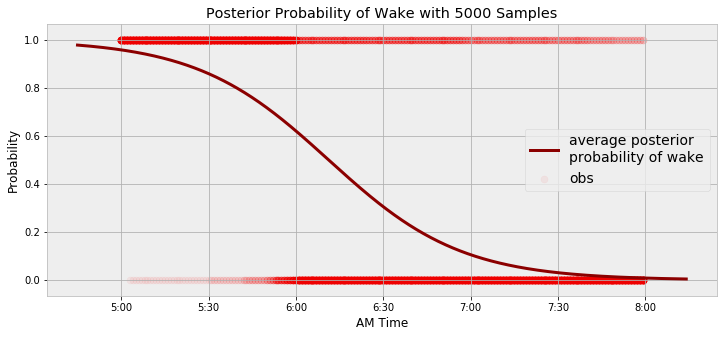

In [29]:
# Extract the alpha and beta samples
# Currently using all, including the burn-in period
alpha_samples = wake_trace["alpha"][:, None]
beta_samples = wake_trace["beta"][:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(12, 5)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="average posterior \nprobability of wake")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Posterior Probability of Wake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('AM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

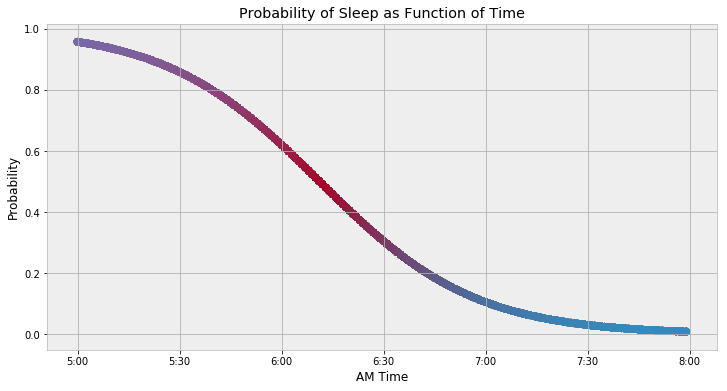

In [30]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('AM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

## Investigate the Model

In [34]:
print('Probability of being awake at 5:30 AM: {:.2f}%.'.format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:00 AM: {:.2f}%.'.format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:30 AM: {:.2f}%.'.format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

Probability of being awake at 5:30 AM: 14.12%.
Probability of being awake at 6:00 AM: 37.96%.
Probability of being awake at 6:30 AM: 69.49%.


## Confidence Intervals (95%)

In [ ]:
wake_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = mquantiles(wake_all_est, [0.025, 0.975], axis=0)

In [ ]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, color='salmon', label = '95% CI')
plt.plot(time_est, wake_est, lw=2, ls='--', color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);
plt.scatter(time, sleep_obs, edgecolor = 'red', facecolor = 'red', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('AM Time'); plt.ylabel('Probability'); plt.title('Posterior Probabilty with 95% CI');

# Length of Sleep 

We can also form a model to estimate the most likely length of time I am asleep. We can first look at the data and then determine which distribution fits best.

In [ ]:
raw_data = pd.read_csv('data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

In [ ]:
figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution'); plt.ylabel('Observations');

The distribution is skewed to the right. Therefore, we can used a skewed distribution to model the length of sleep. 

In [ ]:
import scipy.stats

In [ ]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12, 1e3)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred', normed=True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', lw=3, label='skewnorm pdf');

In [ ]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)
    

In [ ]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew']
mu_samples = duration_trace['mu']
tau_samples = duration_trace['tau']

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

## Visualize Posterior Distribution

In [ ]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Hours'); plt.ylabel('Probability'); plt.title('Posterior Distribution for Duration of Sleep');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), linestyles='--', linewidth=2, color='red', label = 'Most Likely Duration');
plt.show()

print('The most likely duration of sleep is {:.2f} hours.'.format(x[np.argmax(y)]))

### Query the Posterior Model

In [ ]:
print('Probability of at least 6.5 hours of sleep = {:.2f}%.'.format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 8.0 hours of sleep = {:.2f}%.'.format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 9.0 hours of sleep = {:.2f}%.'.format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

## Visualize the Posterior and the Data

In [ ]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)

# Plot the posterior distribution
plt.plot(x, y, color = 'forestgreen', label = 'Posterior Distribution', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# Plot the observed values
plt.hist(duration, bins=10, color = 'red', alpha=0.8, label='Observed', normed=True)
plt.xlabel('Hours'); plt.ylabel('Probability'); plt.title('Observations and Posterior Distribution');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), linestyles='--', linewidth=2, color='k', label = 'Most Likely Duration');
plt.legend(prop={'size':12});

The posterior skewed normal distribution looks to fit the data well. However, the data actually may be better modeled as two separate distributions given the second mode to the right. The second mode is not captured in a single skewed normal distribution.

# Conclusions

This report created three models: 
    * Calculate the probability I am asleep in the evening using a logistic posterior
    * Calculate the probability I am asleep in the morning using a logistic posterior
    * Calculate the probability of the duration of my sleep using a skewed normal posterior. 
    
The results may not be entirely useful, but they could be combined with additional factors such as the day of the week or the daily activities and caffience intake. Nonetheless, this was a great start towards analysis real-world data from a Bayesian viewpoint. I had never used Markov Chain Monte Carlo before this project, and having applied it, I now feel confident extending this to other domains. There were many topics I learned from this project, and I am appreciate the individuals who contributed to my thought process including Robin Cole and the author of _Probabilistic Programming and Bayesian Methods for Hackers_. Learning in the technical age is changing, and this project is a great example because I got the idea from a friend working on an open-source project, and learned how to use all the methods from a free book. The project itself may not be that significant, but what I have learned will be of great use and I look forward to using more Bayesian inference methods. 